In [97]:
import time
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import polars as pl
from functools import reduce
import duckdb

import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)

# container to keep adding results across runs
results = {}

3.10.7


# Method 1: Pandas dataframes

In [98]:
# Start timer
start_time = time.time()

df1 = pq.read_table("data.parquet").to_pandas()
df2 = pq.read_table("data_modified.parquet").to_pandas()

match_rate = (df1 == df2).all(axis=1).mean()
print(f"Row-level match rate: {match_rate:.10f}")

# End timer
end_time = time.time()
elapsed_time = end_time - start_time

# Add entry under key 'Pandas'
results["Pandas"] = {
    "match_rate": round(match_rate, 10),
    "time_taken_sec": round(elapsed_time, 10)
}

print(results)

Row-level match rate: 0.9999714286
{'Pandas': {'match_rate': 0.9999714286, 'time_taken_sec': 11.4324762821}}


# Method 2: SQL via duckDB

In [99]:
import time
import duckdb

def quote_ident(col: str) -> str:
    # DuckDB identifiers are double-quoted; escape any embedded quotes
    return '"' + col.replace('"', '""') + '"'

# Start timer
start_time = time.time()
con = duckdb.connect()

# Build a NULL-safe equality condition across all columns
eq_conditions = " AND ".join(
    f"(t1.{quote_ident(c)} IS NOT DISTINCT FROM t2.{quote_ident(c)})" for c in cols
)

# Use row_number() to compare row i vs row i (since files are already sorted)
query = f"""
WITH
t1 AS (
  SELECT ROW_NUMBER() OVER () AS rn, * FROM read_parquet('data.parquet')
),
t2 AS (
  SELECT ROW_NUMBER() OVER () AS rn, * FROM read_parquet('data_modified.parquet')
),
joined AS (
  SELECT {eq_conditions} AS row_match
  FROM t1
  JOIN t2 USING (rn)
)
SELECT AVG(CASE WHEN row_match THEN 1 ELSE 0 END)::DOUBLE AS match_rate
FROM joined;
"""

match_rate = con.execute(query).fetchone()[0]
print(f"Row-level match rate: {match_rate:.10f}")

# End timer
end_time = time.time()
elapsed_time = end_time - start_time

# Add entry under key 'DuckDB'
results["DuckDB"] = {
    "match_rate": round(match_rate, 10),
    "time_taken_sec": round(elapsed_time, 10)
}

print(results)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Row-level match rate: 0.9999714286
{'Pandas': {'match_rate': 0.9999714286, 'time_taken_sec': 11.4324762821}, 'DuckDB': {'match_rate': 0.9999714286, 'time_taken_sec': 4.9804046154}}


# Method 3: Polars

In [100]:
# Start timer
start_time = time.time()

# Read Parquet files using Polars
df1 = pl.read_parquet("data.parquet")
df2 = pl.read_parquet("data_modified.parquet")

# Compute row-level match rate
# (df1 == df2) gives a Boolean DataFrame
# .row(eq=True) checks if all values in the row are True
match_rate = (df1 == df2).rows().count((True,) * df1.width) / df1.height

# Print result
print(f"Row-level match rate: {match_rate:.10f}")

# End timer
end_time = time.time()
elapsed_time = end_time - start_time

# Add entry under key 'Polars'
results["Polars"] = {
    "match_rate": round(match_rate, 10),
    "time_taken_sec": round(elapsed_time, 10)
}
print(results)


Row-level match rate: 0.9999714286
{'Pandas': {'match_rate': 0.9999714286, 'time_taken_sec': 11.4324762821}, 'DuckDB': {'match_rate': 0.9999714286, 'time_taken_sec': 4.9804046154}, 'Polars': {'match_rate': 0.9999714286, 'time_taken_sec': 4.8158845901}}


# Method 4: Polars Streaming

In [101]:
# Start timer
start_time = time.time()

# Lazily stream from Parquet (no pandas conversion)
l1 = pl.scan_parquet("data.parquet")
l2 = pl.scan_parquet("data_modified.parquet")

# Get column names without forcing full resolution (avoids the warning)
cols = l1.collect_schema().names()

# Row-level hash via struct hashing (version-proof-ish; seed pins current version)
h1 = l1.select(pl.struct(cols).hash(seed=0).alias("h"))
h2 = l2.select(pl.struct(cols).hash(seed=0).alias("h"))

# Attach a row index to preserve order, then join on index
h1i = h1.with_row_index("rn")
h2i = h2.with_row_index("rn")

# Join and compute match rate; use the non-deprecated engine kw
match_rate = (
    h1i.join(h2i, on="rn", how="inner", suffix="_right")
       .with_columns((pl.col("h") == pl.col("h_right")).alias("row_match"))
       .select(pl.col("row_match").mean())
       .collect(engine="streaming")
       .item()
)

elapsed_time = time.time() - start_time

print(f"Row-level match rate: {match_rate:.10f}")
print(f"Elapsed: {elapsed_time:.3f}s")

# Add entry under key 'Polars Streaming'
results["Polars\n(Streaming)"] = {
    "match_rate": round(match_rate, 10),
    "time_taken_sec": round(elapsed_time, 10)
}
print(results)


Row-level match rate: 0.9999714286
Elapsed: 2.292s
{'Pandas': {'match_rate': 0.9999714286, 'time_taken_sec': 11.4324762821}, 'DuckDB': {'match_rate': 0.9999714286, 'time_taken_sec': 4.9804046154}, 'Polars': {'match_rate': 0.9999714286, 'time_taken_sec': 4.8158845901}, 'Polars\n(Streaming)': {'match_rate': 0.9999714286, 'time_taken_sec': 2.2919049263}}


# Method 5: Read parquet files directly (PyArrow)

In [102]:
path1 = "data.parquet"
path2 = "data_modified.parquet"
batch_size = 7_000_000  # untuned, batch size = table size

num_runs = 5
times = []
match_rate = None  # to store final match rate (same across runs)

for _ in range(num_runs):
    start_time = time.time()

    pf1, pf2 = pq.ParquetFile(path1), pq.ParquetFile(path2)

    # Fast fail if total row counts differ
    if pf1.metadata.num_rows != pf2.metadata.num_rows:
        raise ValueError(f"Total row count mismatch: {pf1.metadata.num_rows} vs {pf2.metadata.num_rows}")

    total_rows = matched_rows = 0

    for b1, b2 in zip(pf1.iter_batches(batch_size=batch_size), pf2.iter_batches(batch_size=batch_size)):
        if b1.num_rows != b2.num_rows or b1.num_columns != b2.num_columns:
            raise ValueError("Batch shape mismatch")

        # Row-wise full equality: AND across all per-column equalities
        row_equal = reduce(
            pc.and_kleene,
            (pc.equal(b1.column(i), b2.column(i)) for i in range(b1.num_columns))
        )

        # Count True values in this batch
        matches_in_batch = int(pc.sum(pc.cast(row_equal, pa.int64())).as_py())
        matched_rows += matches_in_batch
        total_rows += b1.num_rows

    match_rate = matched_rows / total_rows if total_rows else 1.0
    elapsed_time = time.time() - start_time
    times.append(elapsed_time)

avg_time = sum(times) / num_runs

results["PyArrow"] = {
    "match_rate": round(match_rate, 10),
    "time_taken_sec": round(avg_time, 10)
}

print(f"Row-level match rate: {match_rate:.10f}")
print(f"Average time over {num_runs} runs: {avg_time:.6f} sec")
print(results)


Row-level match rate: 0.9999714286
Average time over 5 runs: 1.691497 sec
{'Pandas': {'match_rate': 0.9999714286, 'time_taken_sec': 11.4324762821}, 'DuckDB': {'match_rate': 0.9999714286, 'time_taken_sec': 4.9804046154}, 'Polars': {'match_rate': 0.9999714286, 'time_taken_sec': 4.8158845901}, 'Polars\n(Streaming)': {'match_rate': 0.9999714286, 'time_taken_sec': 2.2919049263}, 'PyArrow': {'match_rate': 0.9999714286, 'time_taken_sec': 1.6914967537}}


# Method 6: Read parquet files directly with tuned batch processing

In [103]:
path1 = "data.parquet"
path2 = "data_modified.parquet"

# Testing different batch sizes
batch_sizes = list(range(10_000, 300_001, 10_000))  # 10k → 1M in 10k steps
batch_times = []

for bs in batch_sizes:
    start_time = time.time()

    pf1, pf2 = pq.ParquetFile(path1), pq.ParquetFile(path2)

    total_rows = matched_rows = 0
    for b1, b2 in zip(pf1.iter_batches(batch_size=bs), pf2.iter_batches(batch_size=bs)):
        row_equal = reduce(
            pc.and_kleene,
            (pc.equal(b1.column(i), b2.column(i)) for i in range(b1.num_columns))
        )
        matched_rows += int(pc.sum(pc.cast(row_equal, pa.int64())).as_py())
        total_rows += b1.num_rows

    elapsed_time = time.time() - start_time
    batch_times.append(elapsed_time)
    print(f"Batch size {bs:,} → {elapsed_time:.4f} sec")

# Find optimal batch size (min time)
optimal_batch_size = batch_sizes[batch_times.index(min(batch_times))]
print(f"\n✅ Optimal batch size: {optimal_batch_size:,} rows\n")

# --- Smoothing (rolling mean) with edge padding ---
window = max(5, len(batch_times) // 10)
if window % 2 == 0:
    window += 1
kernel = np.ones(window, dtype=float) / window

# pad by half-window on each side, then 'valid' to recenter
half = window // 2
padded = np.pad(batch_times, (half, half), mode='reflect')  # or mode='edge'
smoothed_times = np.convolve(padded, kernel, mode='valid')

Batch size 10,000 → 1.9796 sec
Batch size 20,000 → 1.4952 sec
Batch size 30,000 → 1.4599 sec
Batch size 40,000 → 1.3143 sec
Batch size 50,000 → 1.3026 sec
Batch size 60,000 → 1.4407 sec
Batch size 70,000 → 1.3911 sec
Batch size 80,000 → 1.5879 sec
Batch size 90,000 → 1.4105 sec
Batch size 100,000 → 1.3760 sec
Batch size 110,000 → 1.4851 sec
Batch size 120,000 → 1.4057 sec
Batch size 130,000 → 1.4862 sec
Batch size 140,000 → 1.8906 sec
Batch size 150,000 → 1.9384 sec
Batch size 160,000 → 1.4431 sec
Batch size 170,000 → 1.2959 sec
Batch size 180,000 → 1.5981 sec
Batch size 190,000 → 1.7283 sec
Batch size 200,000 → 1.3805 sec
Batch size 210,000 → 1.2327 sec
Batch size 220,000 → 1.2580 sec
Batch size 230,000 → 1.2769 sec
Batch size 240,000 → 1.2578 sec
Batch size 250,000 → 1.2010 sec
Batch size 260,000 → 1.1319 sec
Batch size 270,000 → 1.2842 sec
Batch size 280,000 → 1.3213 sec
Batch size 290,000 → 1.3149 sec
Batch size 300,000 → 1.2552 sec

✅ Optimal batch size: 260,000 rows



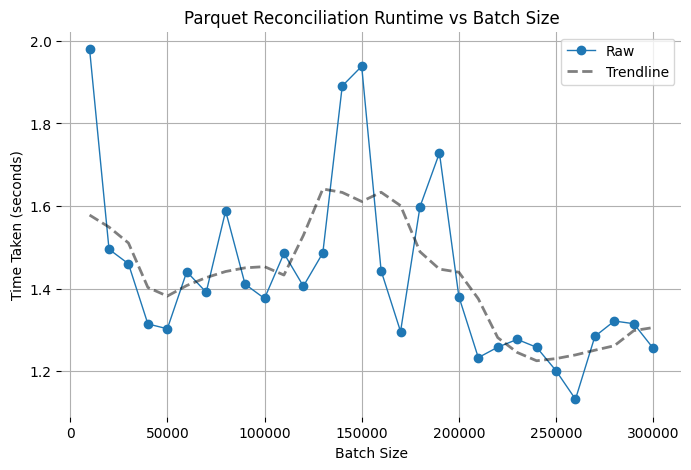

In [ ]:
# --- Plot results (raw + smoothed) ---
plt.figure(figsize=(8, 5))
plt.plot(batch_sizes, batch_times, marker='o', linewidth=1, label='Raw')
plt.plot(
    batch_sizes,
    smoothed_times,
    linewidth=2,
    linestyle='--',   # dotted or dashed line
    alpha=0.5,        # 50% opacity
    color = 'black',
    label=f'Trendline'
)
plt.title("Parquet Reconciliation Runtime vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Time Taken (seconds)")
plt.grid(True)
plt.legend()

# Remove box spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()


In [105]:
path1 = "data.parquet"
path2 = "data_modified.parquet"
batch_size = optimal_batch_size

num_runs = 5
times = []
match_rate = None  # to store final match rate (same across runs)

for _ in range(num_runs):
    start_time = time.time()

    pf1, pf2 = pq.ParquetFile(path1), pq.ParquetFile(path2)

    # Fast fail if total row counts differ
    if pf1.metadata.num_rows != pf2.metadata.num_rows:
        raise ValueError(f"Total row count mismatch: {pf1.metadata.num_rows} vs {pf2.metadata.num_rows}")

    total_rows = matched_rows = 0

    for b1, b2 in zip(pf1.iter_batches(batch_size=batch_size), pf2.iter_batches(batch_size=batch_size)):
        if b1.num_rows != b2.num_rows or b1.num_columns != b2.num_columns:
            raise ValueError("Batch shape mismatch")

        # Row-wise full equality: AND across all per-column equalities
        row_equal = reduce(
            pc.and_kleene,
            (pc.equal(b1.column(i), b2.column(i)) for i in range(b1.num_columns))
        )

        # Count True values in this batch
        matches_in_batch = int(pc.sum(pc.cast(row_equal, pa.int64())).as_py())
        matched_rows += matches_in_batch
        total_rows += b1.num_rows

    match_rate = matched_rows / total_rows if total_rows else 1.0
    elapsed_time = time.time() - start_time
    times.append(elapsed_time)

avg_time = sum(times) / num_runs

results["PyArrow\n(Tuned batch size)"] = {
    "match_rate": round(match_rate, 10),
    "time_taken_sec": round(avg_time, 10)
}

print(f"Row-level match rate: {match_rate:.10f}")
print(f"Average time over {num_runs} runs: {avg_time:.6f} sec")
print(results)


Row-level match rate: 0.9999714286
Average time over 5 runs: 1.254333 sec
{'Pandas': {'match_rate': 0.9999714286, 'time_taken_sec': 11.4324762821}, 'DuckDB': {'match_rate': 0.9999714286, 'time_taken_sec': 4.9804046154}, 'Polars': {'match_rate': 0.9999714286, 'time_taken_sec': 4.8158845901}, 'Polars\n(Streaming)': {'match_rate': 0.9999714286, 'time_taken_sec': 2.2919049263}, 'PyArrow': {'match_rate': 0.9999714286, 'time_taken_sec': 1.6914967537}, 'PyArrow\n(Tuned batch size)': {'match_rate': 0.9999714286, 'time_taken_sec': 1.2543331146}}


# Visualise the results

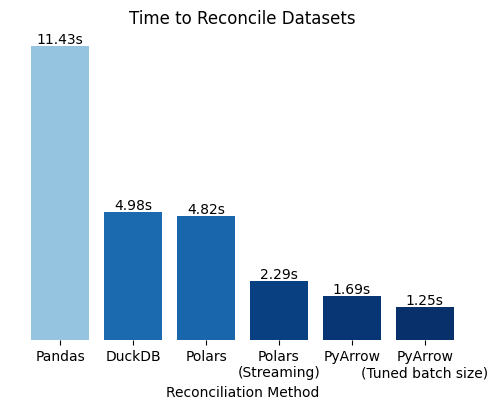

In [106]:
# Visualise the results

# Extract methods and their corresponding times
methods = list(results.keys())
times = [v['time_taken_sec'] for v in results.values()]

# --- Sort results by descending time ---
sorted_data = sorted(zip(methods, times), key=lambda x: x[1], reverse=True)
methods, times = zip(*sorted_data)

# Normalize and color (same logic)
max_time = max(times)
min_time = min(times)
norm_times = [(t - min_time) / (max_time - min_time) if max_time > min_time else 0.5 for t in times]
colors = [plt.cm.Blues(1 - n * 0.6) for n in norm_times]

# --- Plot ---
plt.figure(figsize=(6, 4))
bars = plt.bar(methods, times, color=colors)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}s", 
             ha='center', va='bottom', fontsize=10)

# Titles and labels
plt.title("Time to Reconcile Datasets")
plt.xlabel("Reconciliation Method")

# Remove gridlines and box spines
plt.grid(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Remove y-axis completely
plt.gca().yaxis.set_visible(False)

plt.show()
